In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates


### Functions

In [2]:
def get_data(datafile):
    saltf = datafile.final_salt
    transpf = datafile.final_transp
    lonf = datafile.final_lon
    latf = datafile.final_lat
    depthf = datafile.final_depth
    sectionf = datafile.final_section
    zf = datafile.final_z
    
    return saltf,transpf,lonf,latf,depthf,sectionf,zf
    

In [3]:
#Function to extract data from 1 section

def splitsec(sectionfull,sectionnum,transport,longitude,depth,z):
    idx = np.where(sectionfull==sectionnum)
    transp_sec = transport[idx]
    lon_sec = longitude[idx]
    depth_sec = depth[idx]
    zf_sec = z[idx]
    return transp_sec,lon_sec,depth_sec, zf_sec

In [4]:
#Function that calculates the average m3/s (summing over hours and then dividing by hours that it was seeded for)

def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [5]:
#Calculates all properties for each section

def calculate_all(section, allv, folder, subfolder, lmax):
    final = {}
    mean = {}    
    filename = 'ariane_positions_quantitative.nc'
    fullfile = os.path.join('/ocean/rbeutel/MOAD/analysis-becca/Ariane/', folder, subfolder, filename)
    try:
        if os.stat(fullfile).st_size > 0:
            filegood = True
            data = xr.open_dataset(fullfile)
            final_section = data.variables['final_section'][:]
            final_transport = data.variables['final_transp'][:]
            transport = np.sum(np.where(final_section == section, final_transport, 0)) 
            #transport= the sum of particles through this section (m3/s), same as stats.txt summary once divided by 24
            for variable in allv:
                #this loop calculates the mean values shown in stats.txt final state tables
                if variable == 'final_age':
                    scale = 86400. # convert from seconds to days
                    final[variable] = float('NaN')
                    mean[variable] = float('NaN')
                else:
                    if transport == 0:
                        final[variable] = float('NaN')
                        mean[variable] = float('NaN')
                    else:
                        scale = 1.
                        final[variable] = data.variables[variable][:]/scale
                        mean[variable] = np.sum(np.where(final_section == section, final_transport*final[variable], 0))/transport
        else:
            filegood = False
            transport = float('NaN')
            print ("empty file")
    except OSError:
        filegood = False
        transport = float('NaN')
        print ('Missing Data')
    return filegood, transport/lmax, mean 

In [6]:
def get_data_all(start, endtime, section, allv, folder, subfolder, lmax): 
    #pretty sure the only difference between this and calculate_all is that this one seperates into days (susan wants me to do for whole month)
    timerange = arrow.Arrow.range('day', start, endtime)
    length = (endtime-start).days + 1
    transport = np.zeros(length)
    mean = {}
    for variable in allv:
        mean[variable] = np.zeros(length)
    time = []
    for i, r in enumerate(timerange):
        dir1 = r.format('DDMMMYY').lower()
#        print (dir1)
        filegood, transport[i], meanday = calculate_all(section, allv, folder, subfolder, lmax)
        for variable in allv:
            if filegood:
                mean[variable][i] = meanday[variable]
            else:
                mean[variable][i] = float('NaN')
        time.append(r.datetime)
    return transport[0], mean['final_salt'][0], mean['final_temp'][0]

In [7]:
#Import data and mesh
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

data


<xarray.Dataset>
Dimensions:        (ntraj: 163837)
Dimensions without coordinates: ntraj
Data variables: (12/25)
    init_x         (ntraj) float64 ...
    init_y         (ntraj) float64 ...
    init_z         (ntraj) float64 ...
    init_t         (ntraj) float64 ...
    init_age       (ntraj) timedelta64[ns] ...
    init_transp    (ntraj) float64 ...
    ...             ...
    init_lon       (ntraj) float64 ...
    init_lat       (ntraj) float64 ...
    init_depth     (ntraj) float64 ...
    final_lon      (ntraj) float64 ...
    final_lat      (ntraj) float64 ...
    final_depth    (ntraj) float64 ...
Attributes: (12/108)
    key_roms:                  .FALSE.
    key_mars:                  .FALSE.
    key_symphonie:             .FALSE.
    key_B2C_grid:              .FALSE.
    key_sequential:            .TRUE.
    key_alltracers:            .TRUE.
    ...                        ...
    ind0_sa:                   1
    indn_sa:                   28
    maxsize_sa:                6
    c_suffix_sa:               _grid_T.nc
    nc_var_sa:                 vosaline
    nc_att_mask_sa:            NONE

In [8]:
#This is how you plot showing actual bathymetry
lonE = 308
lonW = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi] #Taking mask for all depths at a specific longitude
tmask = mesh.tmask[0] #Tmask for entire domain
# nav_lon = mesh.nav_lon[latgridi]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi] #glam is just the bottom 
# print(mesh.glamf[0, latgridi].shape)
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonW]-u_lons[lonE])/(mesh.e2f[0, latgridi, lonE:lonW].sum())).values #degrees/m
print(m2lon)



1.0360032205105405e-05


### Transport

In [9]:
#Original boundary

starttime = 1
endtime = 168

meander = 0
puget = 2
deception = 3
rosario = 4
sjc = 5
haro = 6

sectionnum = [meander,puget,deception,rosario,sjc,haro]


[549714.7121161793, 29441.356930736445, 70.28909350509404, 5921.754855595813, 3674.0503695276143, 76335.49015953543]


Text(0.5, 1.0, 'Transport = 665158 (m$^3$/s)')

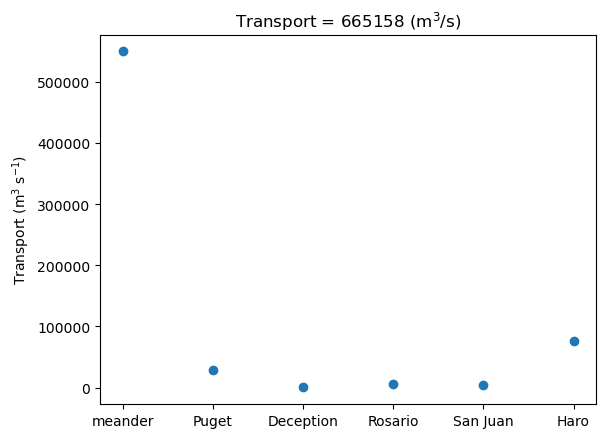

In [10]:
section_trans = []

for section in sectionnum:
    section_trans.append(get_datat(data,section,starttime,endtime))

print(section_trans)

fig,ax = plt.subplots()


sectionplot = sectionnum[0:]
sectionplot[0] = 1

ax.scatter(sectionplot,section_trans)
ax.set_xticks(sectionplot)
ax.set_xticklabels(['meander','Puget','Deception','Rosario','San Juan','Haro']);
ax.set_ylabel(r'Transport (m$^3$ s$^{-1}$)')
ax.set_title(f'Transport = {round(np.sum(section_trans))} (m$^3$/s)')

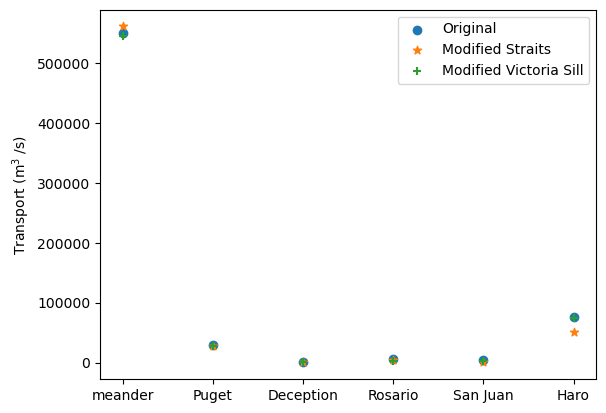

In [11]:
# Alternate boundary for straits
section_transf2 = []

dataf2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18b2/for_straight_01jan18/ariane_positions_quantitative.nc')

for section in sectionnum:
    section_transf2.append(get_datat(dataf2,section,starttime,endtime))

#Alternate boundary for victoria sill
section_transf1 = []

dataf1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18/ariane_positions_quantitative.nc')

for section in sectionnum:
    section_transf1.append(get_datat(dataf1,section,starttime,endtime))


fig,ax = plt.subplots()

ax.scatter(sectionplot,section_trans)
ax.scatter(sectionplot,section_transf2,marker='*')
ax.scatter(sectionplot,section_transf1,marker='+')
ax.set_xticks(sectionplot)
ax.set_xticklabels(['meander','Puget','Deception','Rosario','San Juan','Haro']);
ax.set_ylabel(f'Transport (m$^3$ /s)')
ax.legend(['Original','Modified Straits','Modified Victoria Sill'])

### Boundary Comparison

#### Rosario

In [12]:
#Interpolate data for depth

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [13]:
salt,transp,lon,lat,depth,section,zfinal = get_data(data)

transp_adm,lon_adm,depth_adm,z_adm = splitsec(section,2,transp,lon,depth,zfinal)
transp_ros,lon_ros,depth_ros,z_ros = splitsec(section,4,transp,lon,depth,zfinal)
transp_haro,lon_haro,depth_haro,z_haro = splitsec(section,6,transp,lon,depth,zfinal)
transp_sjc,lon_sjc,depth_sjc,z_sjc = splitsec(section,5,transp,lon,depth,zfinal)

saltf2,transpf2,lonf2,latf2,depthf2,sectionf2,zfinalf2 = get_data(dataf2)

transp_admf2,lon_admf2,depth_admf2,z_admf2 = splitsec(sectionf2,2,transpf2,lonf2,depthf2,zfinalf2)
transp_rosf2,lon_rosf2,depth_rosf2,z_rosf2 = splitsec(sectionf2,4,transpf2,lonf2,depthf2,zfinalf2)
transp_harof2,lon_harof2,depth_harof2,z_harof2 = splitsec(sectionf2,6,transpf2,lonf2,depthf2,zfinalf2)
transp_sjcf2,lon_sjcf2,depth_sjcf2,z_sjcf2 = splitsec(sectionf2,5,transpf2,lonf2,depthf2,zfinalf2)



Text(0.5, 0.98, 'Rosario')

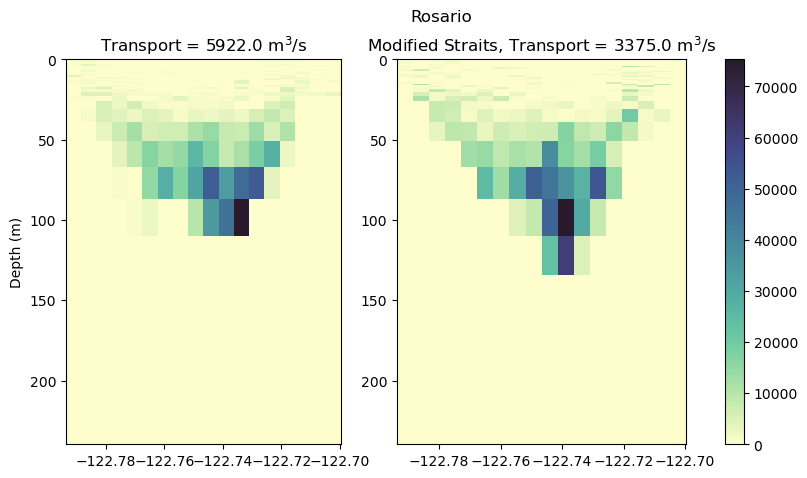

In [14]:

fig, ax = plt.subplots(1,2,figsize=(10,5),gridspec_kw= {'width_ratios':[1,1.05]})
cmap = cm.deep
lonE = 308
lonW = 327

arr,xe,ye,im = ax[0].hist2d(lon_ros,df(z_ros)[0],weights=transp_ros,cmap=cmap,
                             bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:33]], 
                         );

arr2,xe2,ye2,im2 = ax[1].hist2d(lon_rosf2,df(z_rosf2)[0],weights=transp_rosf2,cmap=cmap,
                             bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:33]], 
                         );

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].ticklabel_format(useOffset=False)
ax[0].set_title(f'Transport = {np.round(np.sum(section_trans[rosario-1]))} m$^3$/s')
ax[1].set_title(f'Modified Straits, Transport = {np.round(np.sum(section_transf2[rosario-1]))} m$^3$/s')
ax[0].set_ylabel('Depth (m)')
cb = fig.colorbar(im,ax=ax)
fig.suptitle('Rosario')

#### Haro

Text(0.5, 0.98, 'Haro')

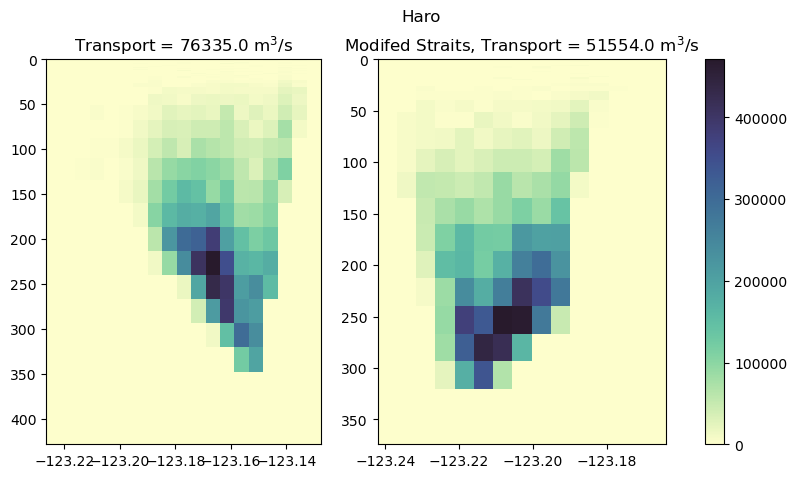

In [15]:
lonE = 225
lonW = 245

fig, ax = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios':[1,1.05]})

arr,xe,ye,im = ax[0].hist2d(lon_haro,df(z_haro)[0],weights=transp_haro,cmap=cmap,
                             bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0]], 
                         );
lonE = 222
lonW = 238

arr2,xe2,ye2,im2 = ax[1].hist2d(lon_harof2,df(z_harof2)[0],weights=transp_harof2,cmap=cmap,
                             bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:38]], 
                         );

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title(f'Transport = {np.round(np.sum(section_trans[haro-1]))} m$^3$/s')
ax[1].set_title(f'Modifed Straits, Transport = {np.round(np.sum(section_transf2[haro-1]))} m$^3$/s')
ax[0].ticklabel_format(useOffset=False)
cb = fig.colorbar(im,ax=ax)
fig.suptitle('Haro')

#### San Juan Channel

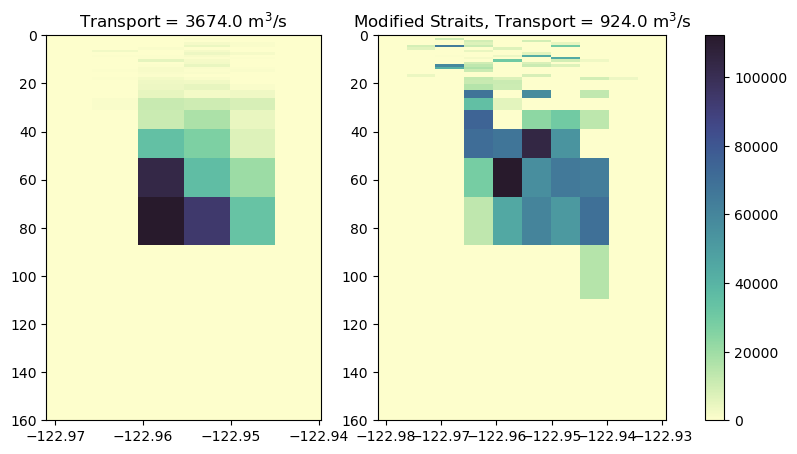

In [16]:
lonE = 274
lonW = 281

fig, ax = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios':[1,1.05]})

arr,xe,ye,im = ax[0].hist2d(lon_sjc,df(z_sjc)[0],weights=transp_sjc,cmap=cmap,
                             bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]], 
                         );

lonE = 272
lonW = 283

arr2,xe2,ye2,im2 = ax[1].hist2d(lon_sjcf2,df(z_sjcf2)[0],weights=transp_sjcf2,cmap=cmap,
                             bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]], 
                         );

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].ticklabel_format(useOffset=False)
ax[1].ticklabel_format(useOffset=False)
ax[0].set_title(f'Transport = {np.round(np.sum(section_trans[sjc-1]))} m$^3$/s')
ax[1].set_title(f'Modified Straits, Transport = {np.round(np.sum(section_transf2[sjc-1]))} m$^3$/s')
cb = fig.colorbar(im,ax=ax)

### Forward / Backwards

In [17]:
databack = xr.open_dataset('back_jan18/for_straight_15jan18_202111_s1t14/ariane_positions_quantitative.nc')
databack01 = xr.open_dataset('back_jan18/for_straight_01jan18_202111_s1t14/ariane_positions_quantitative.nc')
databack28 = xr.open_dataset('back_jan18/for_straight_30jan18_202111_s1t28/ariane_positions_quantitative.nc')

pointrob = 1
gulf1 = 2
gulf2 = 3

sectionnumback = [meander,gulf1,gulf2,rosario,sjc,haro]

Text(0.5, 1.0, 'Backwards - Date comparison')

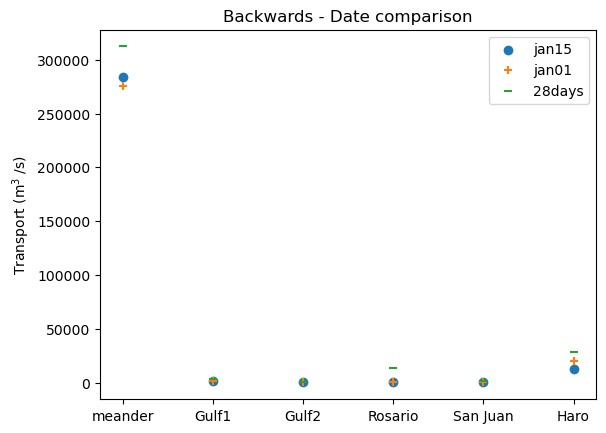

In [31]:
#jan 1 - 15
section_transb = []
starttime = 1
endtime = 25

for section in sectionnumback:
    section_transb.append(get_datat(databack,section,starttime,endtime))

#dec19 - jan01

section_transb1 = []

for section in sectionnumback:
    section_transb1.append(get_datat(databack01,section,starttime,endtime))

#jan01 - jan29

section_transb3 = []

for section in sectionnumback:
    section_transb3.append(get_datat(databack28,section,starttime,endtime))

fig,ax = plt.subplots()

ax.scatter(sectionplot,section_transb)
ax.scatter(sectionplot,section_transb1,marker='+')
ax.scatter(sectionplot,section_transb3,marker='_')
ax.legend(['jan15','jan01','28days'])
ax.set_xticks(sectionplot)
ax.set_ylabel(f'Transport (m$^3$ /s)')
ax.set_xticklabels(['meander','Gulf1','Gulf2','Rosario','San Juan','Haro']);
ax.set_title('Backwards - Date comparison')

In [34]:
saltb,transpb,lonb,latb,depthb,sectionb,zfinalb = get_data(databack)

transp_admb,lon_admb,depth_admb,z_admb = splitsec(sectionb,2,transpb,lonb,depthb,zfinalb)
transp_rosb,lon_rosb,depth_rosb,z_rosb = splitsec(sectionb,4,transpb,lonb,depthb,zfinalb)
transp_harob,lon_harob,depth_harob,z_harob = splitsec(sectionb,6,transpb,lonb,depthb,zfinalb)
transp_sjcb,lon_sjcb,depth_sjcb,z_sjcb = splitsec(sectionb,5,transpb,lonb,depthb,zfinalb)

saltb2,transpb2,lonb2,latb2,depthb2,sectionb2,zfinalb2 = get_data(databack01)

transp_rosb2,lon_rosb2,depth_rosb2,z_rosb2 = splitsec(sectionb2,4,transpb2,lonb2,depthb2,zfinalb2)
transp_harob2,lon_harob2,depth_harob2,z_harob2 = splitsec(sectionb2,6,transpb2,lonb2,depthb2,zfinalb2)
transp_sjcb2,lon_sjcb2,depth_sjcb2,z_sjcb2 = splitsec(sectionb2,5,transpb2,lonb2,depthb2,zfinalb2)

saltb3,transpb3,lonb3,latb3,depthb3,sectionb3,zfinalb3 = get_data(databack28)

transp_rosb3,lon_rosb3,depth_rosb3,z_rosb3 = splitsec(sectionb3,4,transpb3,lonb3,depthb3,zfinalb3)
transp_harob3,lon_harob3,depth_harob3,z_harob3 = splitsec(sectionb3,6,transpb3,lonb3,depthb3,zfinalb3)
transp_sjcb3,lon_sjcb3,depth_sjcb3,z_sjcb3 = splitsec(sectionb3,5,transpb3,lonb3,depthb3,zfinalb3)

#### Rosario

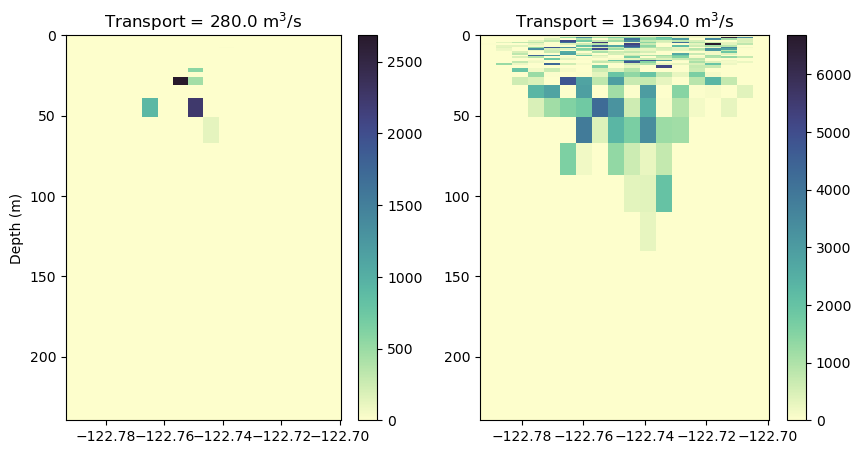

In [44]:
lonE = 308
lonW = 327

fig, ax = plt.subplots(1,2,figsize=(10,5),gridspec_kw= {'width_ratios':[1,1.05]})

arr,xe,ye,im = ax[0].hist2d(lon_rosb,df(z_rosb)[0],weights=transp_rosb,cmap=cmap,
                             bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:33]], 
                         );

arr2,xe2,ye2,im2 = ax[1].hist2d(lon_rosb3,df(z_rosb3)[0],weights=transp_rosb3,cmap=cmap,
                             bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:33]], 
                         );

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].ticklabel_format(useOffset=False)
ax[0].set_title(f'Transport = {np.round(np.sum(section_transb[rosario-1]))} m$^3$/s')
ax[1].set_title(f'Transport = {np.round(np.sum(section_transb3[rosario-1]))} m$^3$/s')
ax[0].set_ylabel('Depth (m)')
cb = fig.colorbar(im,ax=ax[0])
cb2 = fig.colorbar(im2,ax=ax[1])

#### Haro

Text(0.5, 1.0, 'Transport = 28538.0 m$^3$/s')

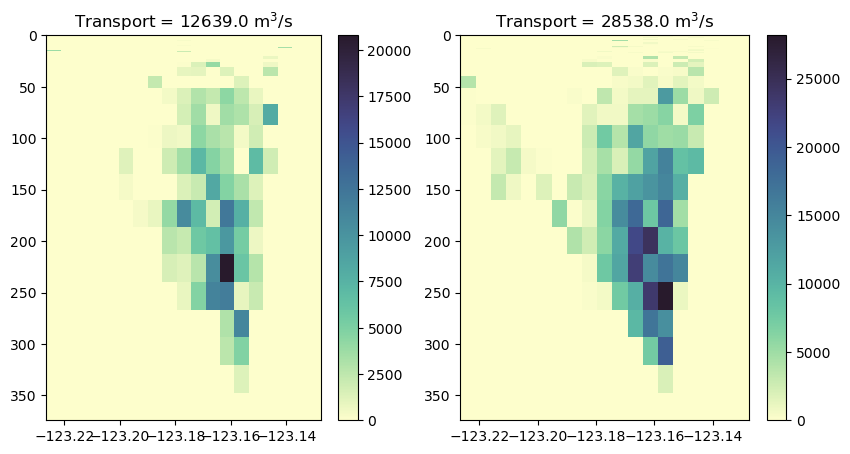

In [50]:
lonE = 225
lonW = 245

fig,ax = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios':[1,1.05]})

arr,xe,ye,im = ax[0].hist2d(lon_harob,df(z_harob)[0],weights=transp_harob,cmap=cmap,
                             bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:38]], 
                         );

arr,xe,ye,im2 = ax[1].hist2d(lon_harob3,df(z_harob3)[0],cmap=cmap,weights=transp_harob3,bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:38]])

ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb = fig.colorbar(im,ax=ax[0])
cb2 = fig.colorbar(im2,ax=ax[1])
ax[0].set_title(f'Transport = {np.round(section_transb[haro-1])} m$^3$/s')
ax[1].set_title(f'Transport = {np.round(section_transb3[haro-1])} m$^3$/s')

#### San Juan

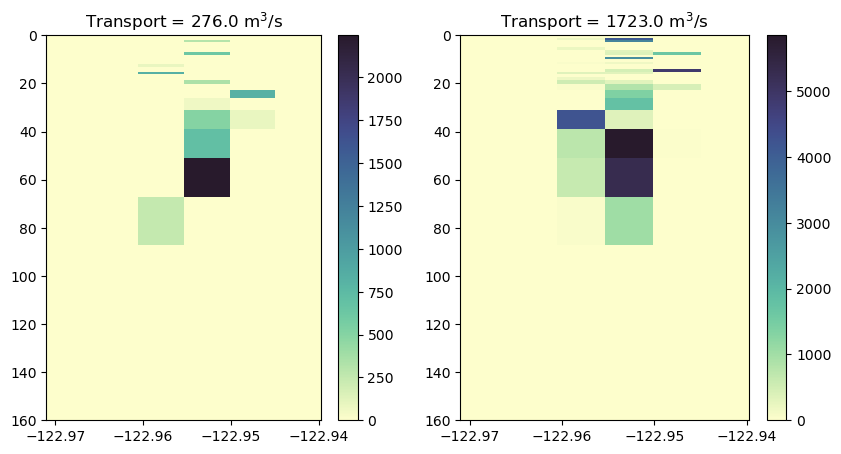

In [57]:
lonE = 274
lonW = 281

fig,ax = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios':[1,1.05]})

arr,xe,ye,im = ax[0].hist2d(lon_sjcb,df(z_sjcb)[0],weights=transp_sjcb,cmap=cmap,bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]])
arr,xe,ye,im2 = ax[1].hist2d(lon_sjcb3,df(z_sjcb3)[0],weights=transp_sjcb3,cmap=cmap,bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]])

cb = fig.colorbar(im,ax=ax[0])
cb2 = fig.colorbar(im2,ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].ticklabel_format(useOffset=False)
ax[1].ticklabel_format(useOffset=False)

ax[0].set_title(f'Transport = {np.round(section_transb[sjc-1])} m$^3$/s')
ax[1].set_title(f'Transport = {np.round(section_transb3[sjc-1])} m$^3$/s');



#### Seeding from Haro

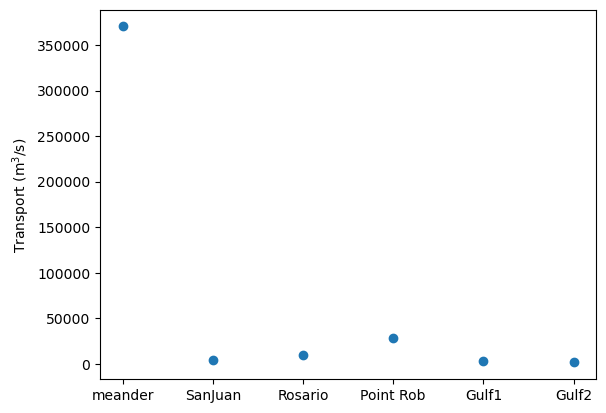

In [23]:
#Import data
datahs = xr.open_dataset('for_jan18_PR/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

starttime = 1
endtime = 168

harohs = 1
sanjuanhs = 2
rosariohs = 3
pointrobhs = 4
gulf1hs = 5
gulf2hs = 6

sectionnumhs = [meander, sanjuanhs, rosariohs,pointrobhs,gulf1hs,gulf2hs ]

section_transphs = []

for section in sectionnumhs:
    section_transphs.append(get_datat(datahs,section,starttime,endtime,))
    
    
section_transphs

fig,ax = plt.subplots()

ax.scatter(sectionplot,section_transphs)
ax.set_xticks(sectionplot)
ax.set_xticklabels(['meander','SanJuan','Rosario','Point Rob','Gulf1','Gulf2'])
ax.set_ylabel(f'Transport (m$^3$/s)');

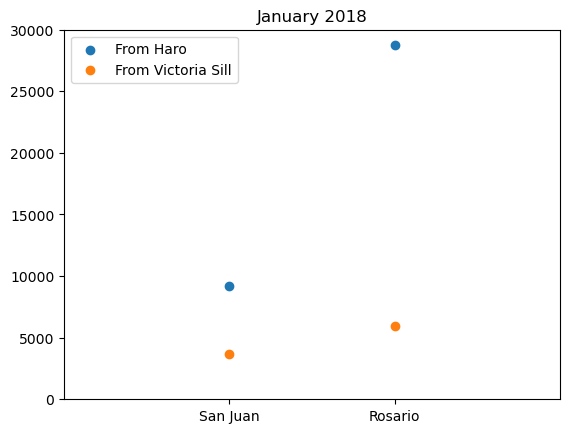

In [24]:
# Compare transport to san juan and rosario from haro vs. from victoria sill

fig,ax = plt.subplots()

section_transp100 = section_transphs[2:4]
section_transp101 = np.array([section_trans[sjc-1],section_trans[rosario-1]])

ax.scatter([1,2],section_transp100)
ax.scatter([1,2],section_transp101)
ax.set_ylim(0,30000)
ax.legend(['From Haro','From Victoria Sill'])
ax.set_xticks([1,2])
ax.set_xticklabels(['San Juan','Rosario'])
ax.set_xlim(0,3)
ax.set_title('January 2018');

##### Section plots

In [25]:
salths,transphs,lonhs,laths,depthhs,sectionhs,zfinalhs = get_data(datahs)

trans_roshs,lon_roshs,depth_roshs,z_roshs = splitsec(sectionhs,3,transphs,lonhs,depthhs,zfinalhs)
trans_sjchs,lon_sjchs,depth_sjchs,z_sjchs = splitsec(sectionhs,2,transphs,lonhs,depthhs,zfinalhs)
trans_prhs,lon_prhs,depth_prhs,z_prhs = splitsec(sectionhs,4,transphs,lonhs,depthhs,zfinalhs)

##### Rosario

Text(0.5, 1.0, 'Transport = 9164.0 (m$^3$/s)')

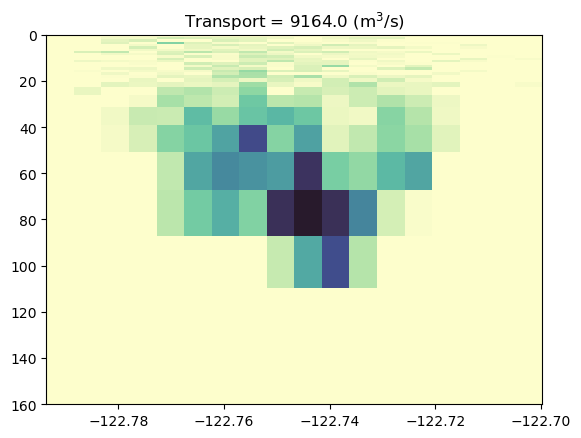

In [26]:
lonE = 308
lonW = 327

fig,ax = plt.subplots()

ax.hist2d(lon_roshs,df(z_roshs)[0],weights=trans_roshs,cmap=cmap,
          bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]]
          )

ax.invert_yaxis()
ax.set_title(f'Transport = {np.round(section_transphs[rosariohs-1])} (m$^3$/s)')

##### San Juan Channel

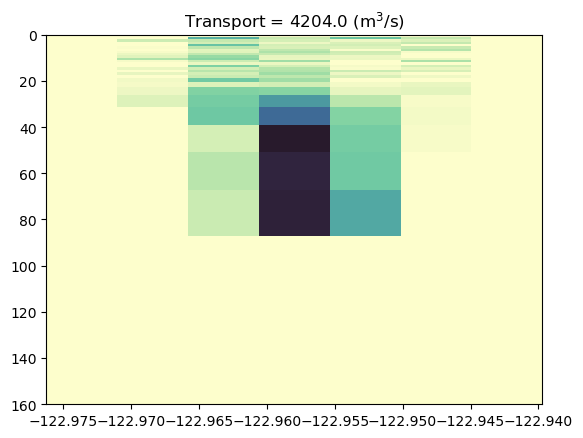

In [27]:
lonE = 273
lonW = 281

fig,ax = plt.subplots()

ax.hist2d(lon_sjchs,df(z_sjchs)[0],weights=trans_sjchs,cmap=cmap,bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]])

ax.invert_yaxis()
ax.ticklabel_format(useOffset=False)
ax.set_title(f'Transport = {np.round(section_transphs[sanjuanhs-1])} (m$^3$/s)');

##### Point Roberts

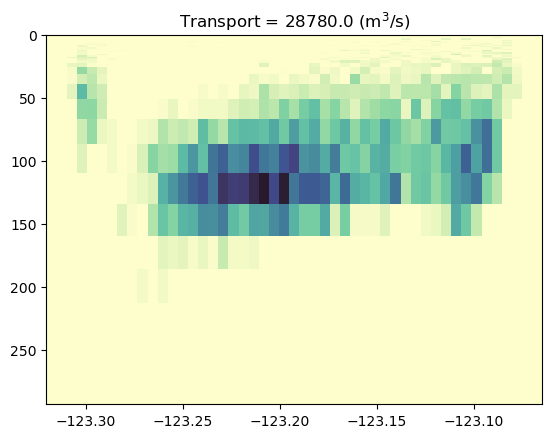

In [28]:
lonE = 207
lonW = 257

fig,ax = plt.subplots()

ax.hist2d(lon_prhs,df(z_prhs)[0],weights=trans_prhs,cmap=cmap,bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:35]])

ax.set_title(f'Transport = {np.round(section_transphs[pointrobhs-1])} (m$^3$/s)')
ax.invert_yaxis();

##### Comparision

##### Rosario

Text(0.5, 0.98, 'Rosario')

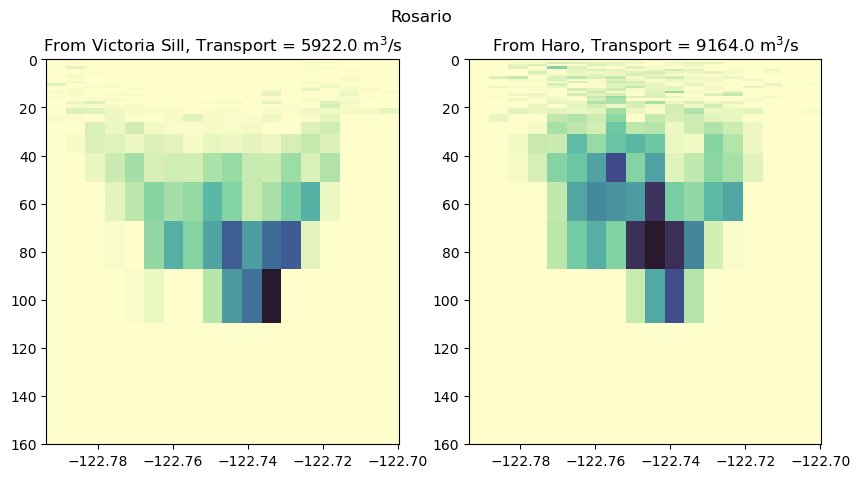

In [29]:
lonE = 308
lonW = 327

fig,ax = plt.subplots(1,2,figsize=(10,5))

arr,xe,ye,im = ax[0].hist2d(lon_ros,df(z_ros)[0],weights=transp_ros,cmap=cmap,bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]])
arr2,xe2,ye2,im2 = ax[1].hist2d(lon_roshs,df(z_roshs)[0],weights=trans_roshs,cmap=cmap,bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]])

ax[0].invert_yaxis()
ax[1].invert_yaxis()

ax[0].set_title(f'From Victoria Sill, Transport = {np.round(section_trans[rosario-1])} m$^3$/s')
ax[1].set_title(f'From Haro, Transport = {np.round(section_transphs[rosariohs-1])} m$^3$/s')
fig.suptitle('Rosario')

##### San Juan

Text(0.5, 0.98, 'San Juan Channel')

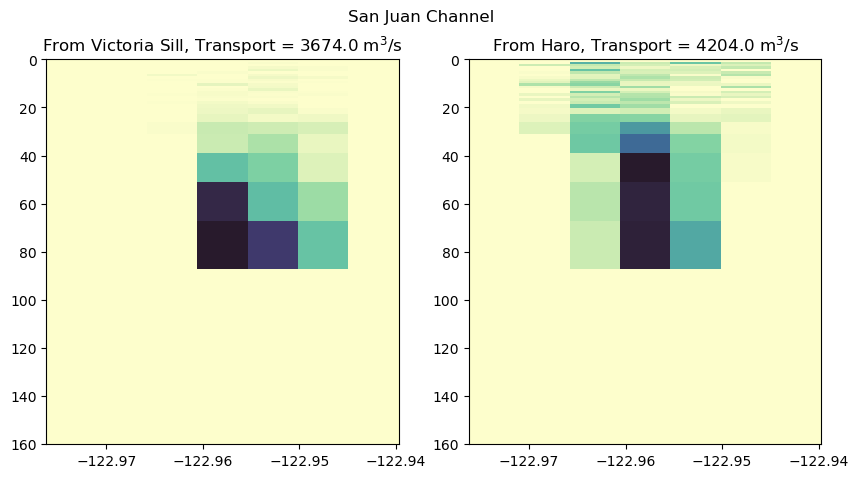

In [30]:
lonE = 273
lonW = 281

fig,ax = plt.subplots(1,2,figsize=(10,5))

arr,xe,ye,im = ax[0].hist2d(lon_sjc,df(z_sjc)[0],weights=transp_sjc,cmap=cmap,bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]])
arr2,xe2,ye2,im2 = ax[1].hist2d(lon_sjchs,df(z_sjchs)[0],weights=trans_sjchs,cmap=cmap,bins=[np.array(f_lons[lonE:lonW:1]),w_depths[0,0:30]])

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].ticklabel_format(useOffset=False)
ax[1].ticklabel_format(useOffset=False)

ax[0].set_xticks(np.around(np.linspace(-122.97,-122.940,4),decimals=3))
ax[1].set_xticks(np.around(np.linspace(-122.97,-122.940,4),decimals=3));
ax[0].set_title(f'From Victoria Sill, Transport = {np.round(section_trans[sjc-1])} m$^3$/s')
ax[1].set_title(f'From Haro, Transport = {np.round(section_transphs[sanjuanhs-1])} m$^3$/s')
fig.suptitle('San Juan Channel')
